# Saturation mutagenesis plots, Tewhey data

In [8]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
#from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.distributions.categorical import Categorical
# from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
# from pymeme import streme, parse_streme_output

from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

import dmslogo
import palettable
import dmslogo.colorschemes
from dmslogo.colorschemes import CBPALETTE

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Functions not yet added to the repo

In [2]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

## Load the model

In [3]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



archive unpacked in ./


## Load data

In [4]:
satmut_df = pd.read_csv('gs://syrgoth/data/saturation_mutagenesis/DNM_sknsh_with_seqs.txt', sep='\t')

#filters
df_temp = satmut_df[(satmut_df.Project != 'negCtrl') &  (satmut_df.Project != 'posCtrl')].reset_index(drop=True)

regions = [snp for snp in sorted(set(df_temp.SNP)) if '-' in snp]
regions

['chr14:29859932-29860132',
 'chr14:37559109-37559309',
 'chr14:57553315-57553515',
 'chr17:2095085-2095285',
 'chr17:2095258-2095458',
 'chr19:30843409-30843609',
 'chr1:47041104-47041304',
 'chr1:87795605-87795805',
 'chr1:90847872-90848072',
 'chr2:60077721-60077921',
 'chr3:136760181-136760381',
 'chr3:19028436-19028636',
 'chr4:147215670-147215870',
 'chr5:87852766-87852966',
 'chr6:136595273-136595473',
 'chr6:14501550-14501750',
 'chr6:91342117-91342317',
 'chr7:100480515-100480715',
 'chr7:114999468-114999668',
 'chr7:114999561-114999761']

## Get in-vitro and in-silico variant effects for all regions

In [5]:
# MPRA cell type and predictor
cell_type = 2
#predictor = mpra_predictor(model=model, pred_idx=cell_type).cuda()
predictor = mpra_predictor(model=model, pred_idx=cell_type, dual_pred=True).cuda()

#In-vitro saturation mutagenesis
effect_tensor_dict = {}
for region in regions:
    region_df = df_temp[(df_temp.SNP == region) & (df_temp.strand == 'fwd')]
    ref_sequence_df = region_df[region_df['Row.names'] == region_df['SNP']]
    if len(ref_sequence_df) == 1:
        num_variants = len(set(region_df['Row.names'])) - 1
        ref_id = ref_sequence_df['Row.names'].values[0]
        ref_sequence = ref_sequence_df['nt_sequence'].values[0]
        ref_lfc = float(ref_sequence_df['log2FoldChange'])
        ref_lfcSE = float(ref_sequence_df['lfcSE'])

        effect_tensor = torch.zeros((4, len(ref_sequence)))
        lfcSE_tensor = torch.zeros((4, len(ref_sequence)))
        for idx, row in region_df.iterrows():
            alt_id = row['Row.names']
            if alt_id != ref_id:
                mutation_info = alt_id.split(':')[-1]
                ref_base = mutation_info[0]
                alt_base = mutation_info[-1]
                site_idx = int(mutation_info[1:-1]) - 1        
                alt_lfc = row['log2FoldChange']
                alt_lfcSE = row['lfcSE']
                effect_tensor[constants.STANDARD_NT.index(alt_base), site_idx] = alt_lfc - ref_lfc
                lfcSE_tensor[constants.STANDARD_NT.index(alt_base), site_idx] = alt_lfcSE
        effect_tensor_dict[region] = {'ref_sequence': ref_sequence,
                                      'ref_lfc': ref_lfc,
                                      'ref_lfcSE': ref_lfcSE,
                                      'mpra_effect': effect_tensor,
                                      'num_mpra_alts': num_variants,
                                      'lfcSE_tensor': lfcSE_tensor
                                     }
        
#In-silico saturation mutagenesis
batch_tensor = torch.stack([utils.dna2tensor(dicti['ref_sequence']) for dicti in effect_tensor_dict.values()])
ref_predictions = predictor(batch_tensor.cuda()).detach().cpu()

all_ref_sequences = [dicti['ref_sequence'] for dicti in effect_tensor_dict.values()]

predicted_saturations = []
for sequence_as_string in tqdm(all_ref_sequences):
    combinations = []
    for idx in range(len(sequence_as_string)):
        four_combinations = torch.stack([utils.dna2tensor(sequence_as_string[:idx] + base + sequence_as_string[idx+1:]) for base in constants.STANDARD_NT])
        combinations.append(four_combinations)
    combinations = torch.stack(combinations).flatten(0,1)
    
    ref_tensor = utils.dna2tensor(sequence_as_string)
    base_prediction = predictor(ref_tensor.view(1,4,-1).cuda()).detach().cpu()
    sat_preds = predictor(combinations.cuda()).detach().cpu()
    
    out_tensor = (sat_preds.unflatten(0, (200, 4)).T - base_prediction) * (torch.ones_like(ref_tensor) - ref_tensor)
    predicted_saturations.append(out_tensor)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/19 [00:00<?, ?it/s]

In [6]:
dict_by_lfc = {}
dict_by_idx = {}
for idx, key in enumerate(effect_tensor_dict.keys()):
    dict_by_lfc[key] = float(effect_tensor_dict[key]['ref_lfc'])
    dict_by_idx[key] = idx
dict_by_lfc = dict(sorted(dict_by_lfc.items(), key = lambda item: item[1], reverse=True))
print(list(dict_by_lfc.keys()))

['chr17:2095258-2095458', 'chr6:14501550-14501750', 'chr7:114999561-114999761', 'chr17:2095085-2095285', 'chr6:136595273-136595473', 'chr7:100480515-100480715', 'chr14:57553315-57553515', 'chr14:29859932-29860132', 'chr6:91342117-91342317', 'chr3:19028436-19028636', 'chr1:47041104-47041304', 'chr5:87852766-87852966', 'chr19:30843409-30843609', 'chr3:136760181-136760381', 'chr7:114999468-114999668', 'chr1:90847872-90848072', 'chr14:37559109-37559309', 'chr2:60077721-60077921', 'chr4:147215670-147215870']


## Variant effect predictions scatter plot

chr17:2095258-2095458 | ref lfc: 1.9521 | pred lfc: 1.5476 | ref lfcSE: 0.0806 | Pearson: 0.85


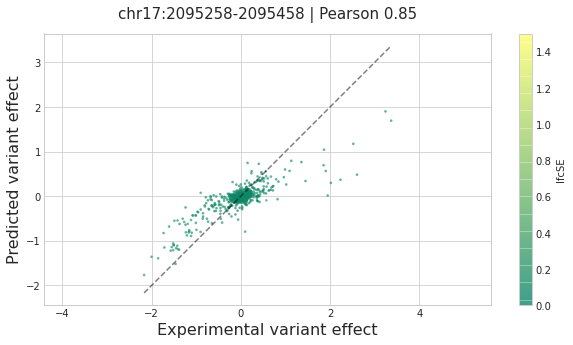

In [9]:
key = 'chr17:2095258-2095458'

idx = dict_by_idx[key]
tensor_dict = effect_tensor_dict[key]
num_variants = effect_tensor_dict[key]['num_mpra_alts']

assert num_variants == 600

ref_sequence = tensor_dict['ref_sequence']
ref_lfc = effect_tensor_dict[key]['ref_lfc']
exp_effect_array = tensor_dict['mpra_effect'].numpy()
lfcSE_array = tensor_dict['lfcSE_tensor'].numpy()

effect_means = - exp_effect_array.sum(axis=0) / 3.0
lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
ref_lfcSE = tensor_dict['ref_lfcSE']
lfcSE_maxs = lfcSE_array.max(axis=0)

pred_effect_array = predicted_saturations[idx].detach().numpy()
pred_effect_means = - pred_effect_array.sum(axis=0) / 3.0
pred_lfc = round(float(ref_predictions[idx,...]), 4)

#salient_map = salient_maps[idx].detach().numpy().sum(axis=0)

a, b = exp_effect_array.flatten(), pred_effect_array.flatten()
#a, b = a[np.nonzero(b)], b[np.nonzero(b)]
pearson = round(np.corrcoef(a, b)[0,1], 2)
spearman = round(stats.spearmanr(a, b)[0], 2)

print(f'{key} | ref lfc: {round(ref_lfc, 4)} | pred lfc: {pred_lfc} | ref lfcSE: {round(ref_lfcSE, 4)} | Pearson: {pearson}')

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,5))
    #colors = np.arange(0, a.shape[0])
    colors = np.maximum(lfcSE_array, ref_lfcSE * np.ones_like(lfcSE_array))
    #colors = np.maximum(lfcSE_maxs, ref_lfcSE * np.ones_like(lfcSE_means))
    cm = plt.cm.get_cmap('summer')

    plt.scatter(a, b, alpha=0.5, c=colors, cmap=cm, marker='.', s=12.0)
    plt.colorbar(label='lfcSE')
    plt.clim(0, 1.5) 

    x_min, y_min = a.min(), b.min()
    x_max, y_max = a.max(), b.max()
    min_point, max_point = min(x_min, y_min), max(x_max, y_max)
    plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)
    #plt.plot((-2, 2), (-2, 2), color='black', linestyle='--', alpha=0.5)
#             plt.axhline(0, color='red', alpha=0.2, linestyle='--') # x = 0
#             plt.axvline(0, color='red', alpha=0.2, linestyle='--') # y = 0
    plt.axis('equal')
    #plt.ylim(-2, 2)
    #plt.title(f'{key} | ref_lfc: {round(ref_lfc, 4)} | ref_SE: {round(ref_lfcSE, 4)} | Pearson: {pearson}')
    #plt.title(f'{key} | Pearson={pearson}  Spearman={spearman}', fontsize=15, pad=15, fontweight='medium')
    plt.title(f'{key} | Pearson {pearson}', fontsize=15, pad=15, fontweight='medium')
    plt.xlabel('Experimental variant effect', fontsize=16)
    plt.ylabel('Predicted variant effect', fontsize=16)
#     fig_path = 'figures/' + f'{key}_scatter' + '.png'
#     plt.savefig(fig_path, transparent=True )

    fig_path = 'figures/' + f'{key}_scatter' + '.pdf'
    plt.savefig(fig_path)
    plt.show()


## Variant effect stem plots

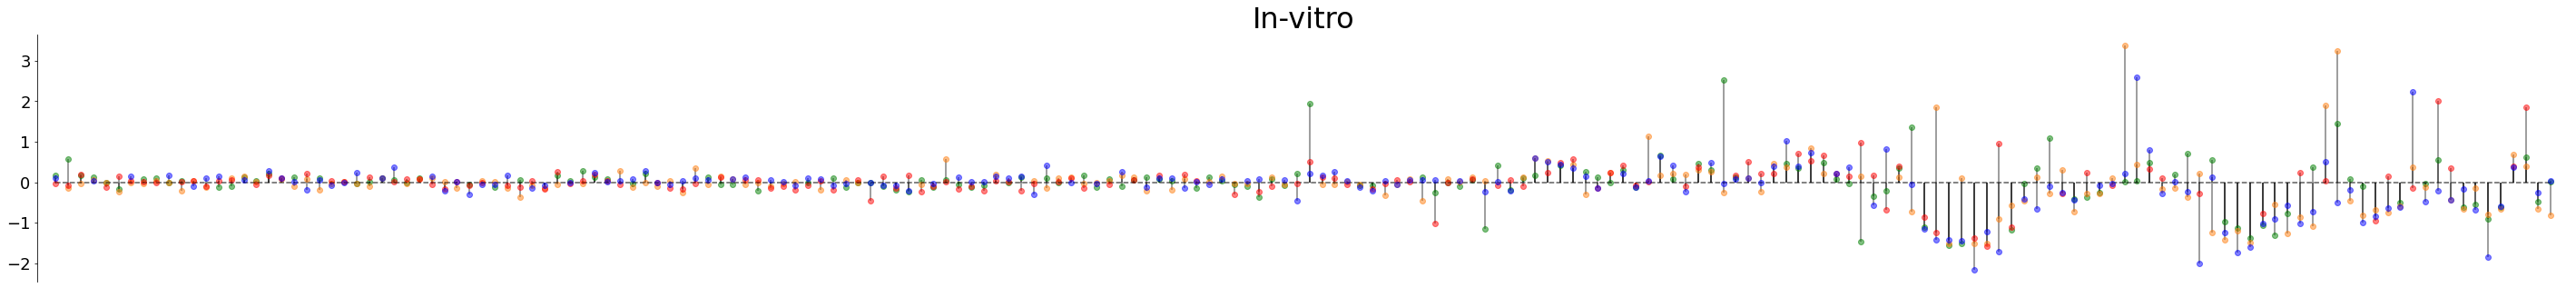

In [11]:
# settings
effect_array = exp_effect_array
colors       = ['g', 'C1', 'r', 'b']
figsize      = (50,5)
stem_offset  = 0.0
marker_alpha = 0.5
stem_alpha   = 0.5
linestyle    = 'solid'

#plot
markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=figsize)

offset = 0
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    offset += stem_offset
    
plt.margins(x=0.0075)
#plt.ylim(y_min, y_max)
#plt.axis('off')
plt.xticks([])
#plt.box(False)
plt.yticks(fontsize=18)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('In-vitro', fontsize=32) 
fig_path = 'figures/' + f'{key}_invitro' + '.pdf'
plt.savefig(fig_path)
plt.show()

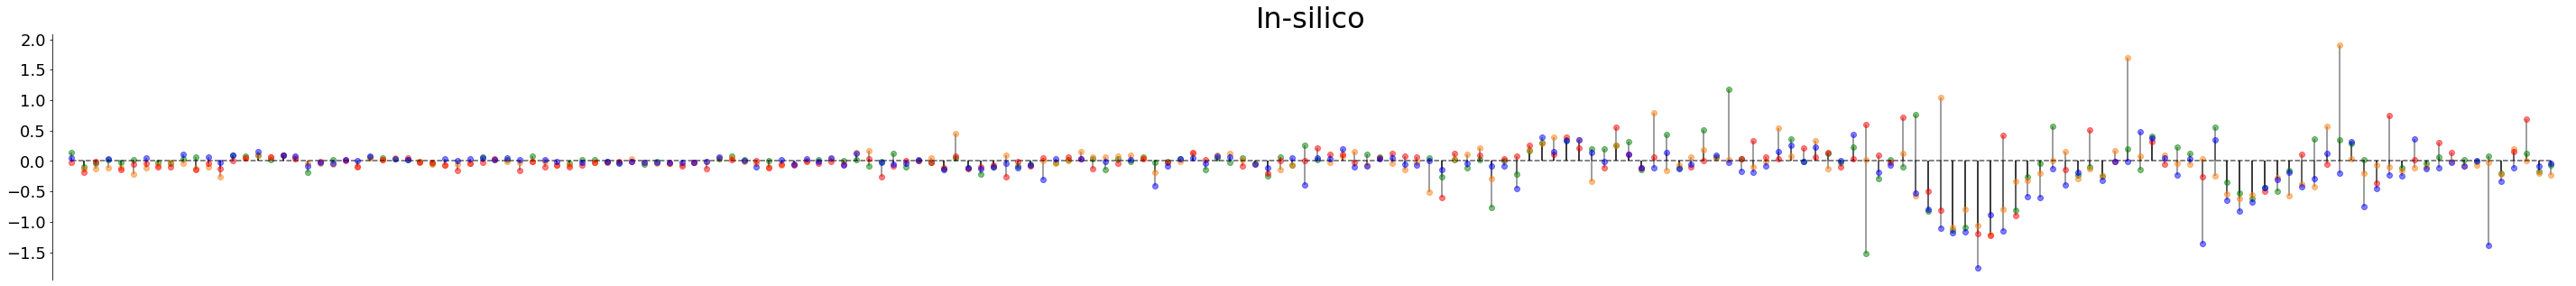

In [12]:
# settings
effect_array = pred_effect_array
colors       = ['g', 'C1', 'r', 'b']
figsize      = (50,5)
stem_offset  = 0.0
marker_alpha = 0.5
stem_alpha   = 0.5
linestyle    = 'solid'

#plot
markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=figsize)

offset = 0
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    offset += stem_offset
    
plt.margins(x=0.0075)
#plt.ylim(y_min, y_max)
#plt.axis('off')
plt.xticks([])
#plt.box(False)
plt.yticks(fontsize=18)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('In-silico', fontsize=32) 
fig_path = 'figures/' + f'{key}_insilico' + '.pdf'
plt.savefig(fig_path)
plt.show()

## Mean variant effect size logos

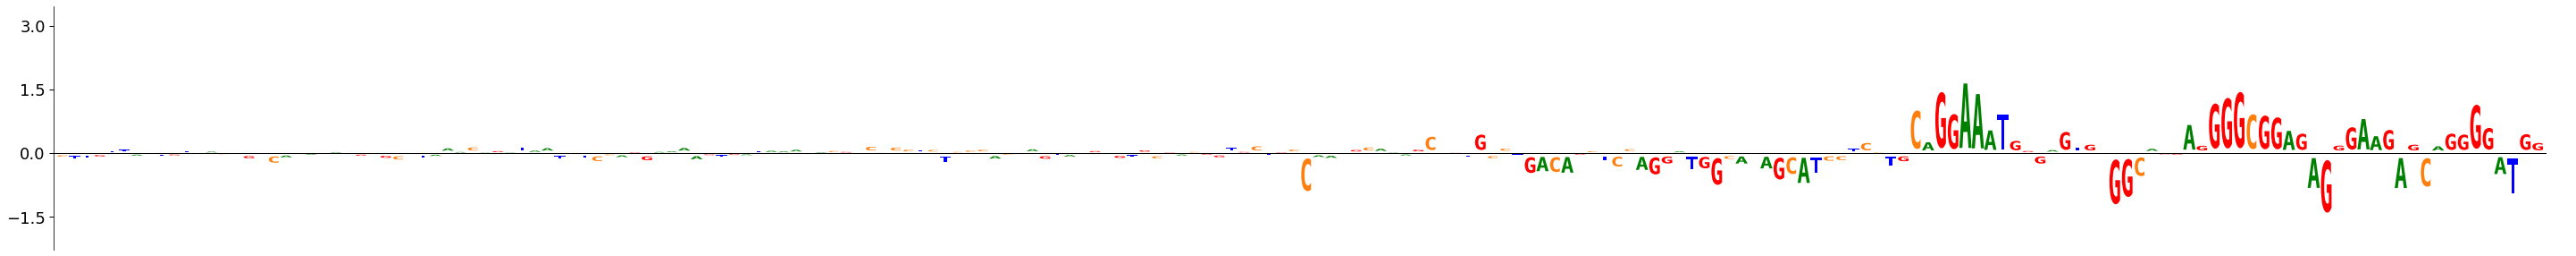

In [10]:
# settings
ref_sequence_str = ref_sequence
contributions_array = exp_effect_array
figsize=(50,5)

#plot
ref_array = utils.dna2tensor(ref_sequence_str).numpy()
effect_array = (np.ones_like(ref_array) - ref_array) * contributions_array

fig, ax = plt.subplots(figsize=(50,5))
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

temp_data = [list(ref_sequence_str), effect_means]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

plt.margins(x=0.0075)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

#plt.box(False)
plt.ylabel('')
plt.yticks(fontsize=18)

plt.show()

## Stems + logo

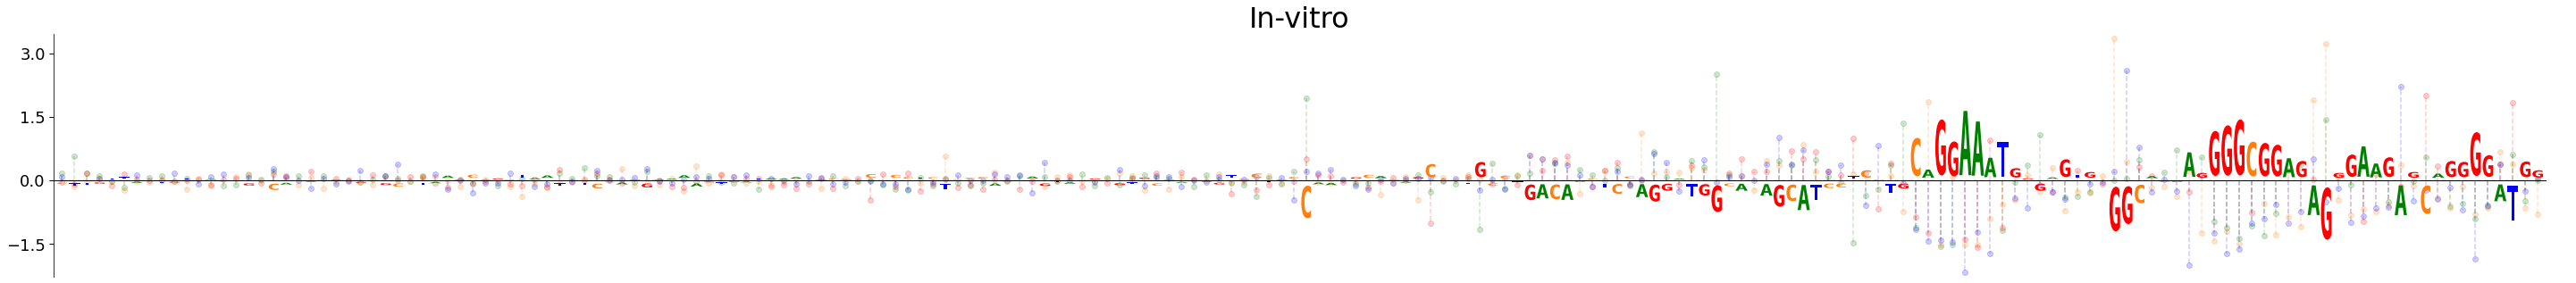

In [11]:
ref_sequence_str = ref_sequence
effect_array     = exp_effect_array
lfcSE_array      = None
ref_lfcSE        = None
colors           = ['g', 'C1', 'r', 'b']
figsize          = (50,5),
marker_alpha     = 0.2
stem_alpha       = 0.2
linestyle        = 'dashed'


markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=(50,5))

offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    #offset += 0.1
    
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

if lfcSE_array is not None and ref_lfcSE is not None:
    lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
    alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
    shade_color_col='color'
    shade_alpha_col='shade'
else:
    alphas = np.empty(effect_means.shape[0])
    alphas[:] = np.nan
    shade_color_col=None
    shade_alpha_col=None

temp_data = [list(ref_sequence_str), effect_means, alphas]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height', 'shade']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        shade_color_col=shade_color_col,
                        shade_alpha_col=shade_alpha_col,
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#plt.title('In-vitro', fontsize=32) 

plt.xticks([])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

plt.ylabel('')
plt.yticks(fontsize=18)
plt.title('In-vitro', fontsize=32) 

plt.show()

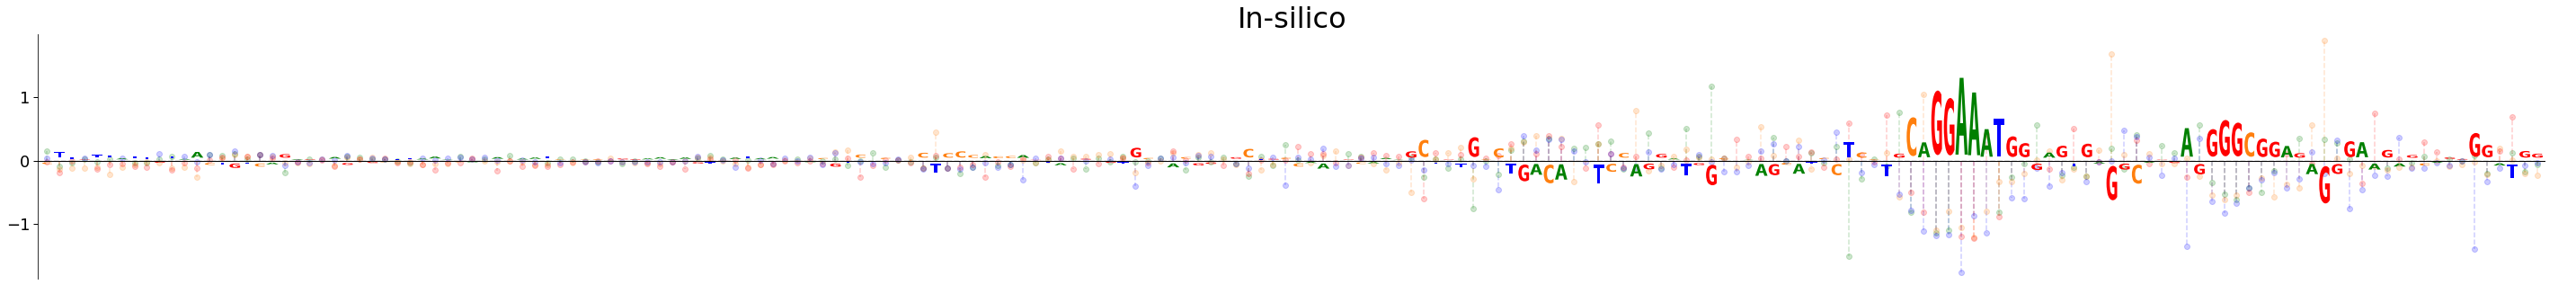

In [12]:
ref_sequence_str = ref_sequence
effect_array     = pred_effect_array
lfcSE_array      = None
ref_lfcSE        = None
colors           = ['g', 'C1', 'r', 'b']
figsize          = (50,5),
marker_alpha     = 0.2
stem_alpha       = 0.2
linestyle        = 'dashed'


markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=(50,5))

offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    #offset += 0.1
    
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

if lfcSE_array is not None and ref_lfcSE is not None:
    lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
    alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
    shade_color_col='color'
    shade_alpha_col='shade'
else:
    alphas = np.empty(effect_means.shape[0])
    alphas[:] = np.nan
    shade_color_col=None
    shade_alpha_col=None

temp_data = [list(ref_sequence_str), effect_means, alphas]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height', 'shade']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        shade_color_col=shade_color_col,
                        shade_alpha_col=shade_alpha_col,
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#plt.title('In-vitro', fontsize=32) 

plt.xticks([])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

plt.ylabel('')
plt.yticks(fontsize=18)
plt.title('In-silico', fontsize=32) 

plt.show()